In [1]:
%run utilities.ipynb

# Conditional edge and interrupt

Dieser Code erstellt einen **Zustandsgraphen** mit bedingten Übergängen zwischen den Knoten und speichert den Verlauf im Speicher:

1. **Zustandsklasse**: Die Klasse `State` enthält die Eingabe (`input`) und eine Liste von Nachrichten (`messages`).

2. **Knotenfunktionen**: Drei Funktionen (`node1`, `node2`, `node3`) definieren die Aktionen in jedem Knoten. 
   - `node1`: Gibt nur eine Nachricht aus.
   - `node2` und `node3`: Setzen Nachrichtenwerte im Zustand auf ihren Knoten-Namen.

3. **Bedingte Übergänge**:
   - Die Funktion `should_continue` überprüft den letzten Nachrichteninhalt:
     - Falls die Nachricht "node1" ist, leitet sie zu `"node2"` weiter.
     - Andernfalls wechselt sie zu `"node3"`.

4. **Graphenerstellung**:
   - Der `StateGraph` beginnt bei `node1`.
   - Bedingte Kanten werden hinzugefügt: von `node1` zu `node2` oder `node3`, abhängig von `should_continue`.
   - Der Graph enthält auch eine Verbindung von `node2` zurück zu `node1` und von `node3` zu `END`.

5. **Speicher und Unterbrechung**: Ein `MemorySaver` speichert den Ablauf, und nach `node1` ist eine Unterbrechung vorgesehen.

6. **Visualisierung**: Der Graph wird als Mermaiddiagramm angezeigt.

Dieser Graph erlaubt es dem Agenten, basierend auf Nachrichteninhalt zwischen den Knoten zu wechseln und den Zustand nachzuverfolgen.

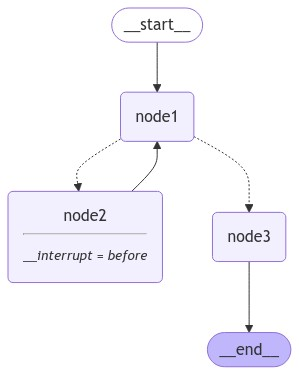

In [2]:
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]


def node1(state:State):
    print("Inside node 1")
    return state 


def node2(state:State):
    print("Inside node2")
    state["messages"]=["inside node2"]
    return state 



def node3(state:State):
    print("Inside node3")
    state["messages"]=["inside node3"]
    return state 


def should_continue(state:State):
    messages = state['messages']
    last_message = messages[-1]
    print("should_continue,last_message",last_message)
    # If the LLM makes a tool call, then we route to the "tools" node
    
    if last_message.content=="go to node2":
        print("continue to:","node2")
        return "node2"
    # Otherwise, we stop (reply to the user)
    else:
        print("continue to:","node3")
        return "node3"


builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.set_entry_point("node1") 


builder.add_conditional_edges(
    "node1",
    should_continue,
    {"node3": "node3", "node2": "node2"},
    )        

builder.add_edge("node2", "node1")

builder.add_edge("node3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory,interrupt_before=["node2"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
thread = {"configurable": {"thread_id": "1"}}
state=State()
state["messages"]=""
# Invoke the graph to process the user input
state = graph.invoke(state, thread)

Inside node 1
should_continue,last_message content='' additional_kwargs={} response_metadata={} id='0257d4d1-5d9b-49be-9151-4e0cf77e9942'
continue to: node3
Inside node3


# Exercise

1.Geben Sie den User Input so ein, dass der Graph zuerst zu node 2 geht.

2.Geben Sie den User Input so ein, dass der Graph gleich zu node 3 geht.

3.Ändern Sie den Graphen so, dass solange node2 ausgefürht wird bis "go to node3" eingegeben wird


In [4]:
# Get user input, replace this with widget
try:
    user_input = input("what next?")
except:
    user_input = "End"

state["messages"] = [("user", user_input)]
state = graph.invoke(state, thread)
print(state)


what next?2
Inside node 1
should_continue,last_message content='2' additional_kwargs={} response_metadata={} id='5b895bd8-4f75-4377-bf04-689dff787d1b'
continue to: node3
Inside node3
{'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='0257d4d1-5d9b-49be-9151-4e0cf77e9942'), HumanMessage(content='inside node3', additional_kwargs={}, response_metadata={}, id='6b7fbb2a-e245-4025-9e43-102853cc412f'), HumanMessage(content='2', additional_kwargs={}, response_metadata={}, id='5b895bd8-4f75-4377-bf04-689dff787d1b'), HumanMessage(content='inside node3', additional_kwargs={}, response_metadata={}, id='d9a060ca-720a-4a5d-b12f-f76594fcf3ed')]}


# Panel App



## Use Invoke

-

Der Code  dient dazu, Benutzereingaben entgegenzunehmen, diese zu verarbeiten und eine Antwort anzuzeigen. Hier ist eine Zusammenfassung der einzelnen Code-Teile:

### 1. `state=State()`
   - Ein globales `state`-Objekt wird initialisiert, um Informationen während der Verarbeitung der Benutzereingaben zu speichern und zu verfolgen, einschließlich der Frage und der generierten Antworten. Es deutet darauf hin, dass `State` eine benutzerdefinierte oder vordefinierte Klasse ist, die den Kontext und den Zustand der Anwendung verwaltet.

### 2. `input_function`
   - Diese Funktion, `input_function`, nimmt einen einzelnen Parameter, `question`, an, der als String erwartet wird und die vom Benutzer gestellte Frage repräsentiert.
   - Innerhalb der Funktion:
      - Das globale `state` wird mit der Frage aktualisiert (`state["input"] = question`).
      - Die Frage wird ebenfalls unter `state["messages"]` gespeichert, wahrscheinlich als Teil einer Nachrichtenfolge oder zur späteren Referenz.
      - Eine hypothetische Funktion `graph.invoke()` wird aufgerufen, die vermutlich die Frage verarbeitet, indem sie mit einem System interagiert (z. B. ein KI-Modell, ein Berechnungsgraph oder eine andere Verarbeitungseinheit). Das `thread`-Dictionary enthält möglicherweise Parameter, die für die Verarbeitung notwendig sind, wie `thread_id`.
      - Die Funktion extrahiert die Antwort aus dem Array `state["messages"]` (angenommen, der letzte Eintrag enthält die Antwort), gibt diese zur Fehlersuche aus und liefert sie als Funktionsergebnis zurück.

### 3. Widget-Einrichtung
   - `question`: Ein `TextInput`-Widget von Panel, das es den Benutzern ermöglicht, ihre Frage einzugeben. Dieses Widget ist mit „Input here please“ beschriftet.
   - `output`: Ein Markdown-Panel, das mit der Antwort auf die Frage aktualisiert wird.

### 4. `button_click`
   - Diese Funktion, `button_click`, behandelt das Klick-Ereignis des Buttons:
      - Sie prüft, ob der `answer_button` angeklickt wurde.
      - Falls ja, bindet sie `input_function` an das `question`-Widget mit `pn.bind()`, um die Eingabe der Frage dynamisch zu übergeben, wenn der Button angeklickt wird.
      - Sie versucht dann, `input_function` aufzurufen und das Ergebnis im `output` zu speichern, wodurch die Antwort in einem Markdown-Panel angezeigt wird. Falls ein Fehler auftritt, wird stattdessen die Fehlermeldung angezeigt.

### 5. Einrichtung des Antwort-Buttons
   - `answer_button`: Ein Button-Widget von Panel, das so konfiguriert ist, dass es `button_click` aufruft, wenn es angeklickt wird.

### 6. Layout und Anzeige
   - `Tab`: Ein Layout, das das Eingabefeld, den Antwort-Button, den Trenner und die Anzeige der Antwort (im Markdown-Format) in einer Spalte anordnet und alles auf die volle Breite streckt.
   - `layout`: Dieses endgültige Layout bettet `Tab` in eine Registerkartenanzeige innerhalb des Panel-Layouts ein, wodurch es benutzerfreundlich wird.

### Zusammenfassung
Dieser Code erstellt eine interaktive, auf Panel basierende Anwendung, die es Benutzern ermöglicht, eine Frage einzugeben, diese durch eine externe Funktion `graph.invoke()` zu verarbeiten und die Antwort anzuzeigen. Das `state`-Objekt verfolgt Benutzereingaben und Antworten, während die Panel-Widgets eine benutzerfreundliche Oberfläche zur Interaktion bereitstellen.

--- 

Das ist die Zusammenfassung auf Deutsch.

In [5]:
state=State()
def input_function(question:str):
    global state
    thread = {"configurable": {"thread_id": "1"}}  

    state["input"]=question
    state["messages"]=question
    
    # Invoke the graph to process the user question
    state = graph.invoke(state, thread)
    answer="the last message from state is"+state["messages"][-1].content
    print("input_function",answer)
    return answer

## Widget für die Eingabe
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
## Panel für die AUsgabe
output = pn.pane.Markdown("Answer")

## Funktion, welche bei buttzon_click der input_function die Frage, welche in das Widget eingegebn wurde übergibt. 
## Das Resultat von input_function wird an den output übetragen, weler in der App angezeigt wird 
def button_click(event):
    if answer_button.clicks > 0:
        bound_function = pn.bind(input_function, question)
        try:
            result = bound_function()
            output.object = f"Start answer:\n {result}"
        except Exception as e:
             output.object = f"Error in start_button_click: {e}"

answer_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)
answer_button.on_click(button_click)

Tab = pn.Column(
            pn.Row(question),
            pn.panel(answer_button, loading_indicator=True, height=50),
            pn.layout.Divider(),
            pn.panel(output, loading_indicator=True, height=900),
            sizing_mode="stretch_width"
        )


layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()

Launching server at http://localhost:56512


Inside node 1
should_continue,last_message content='test' additional_kwargs={} response_metadata={} id='fbbff6ae-63e8-4341-8985-970c8437f138'
continue to: node3
Inside node3
input_function the last message from state isinside node3
Inside node 1
should_continue,last_message content='test' additional_kwargs={} response_metadata={} id='80eb07c1-2b00-4794-b9f9-853fadee1548'
continue to: node3
Inside node3
input_function the last message from state isinside node3
Inside node 1
should_continue,last_message content='test' additional_kwargs={} response_metadata={} id='da643ce7-90f9-4e30-9171-882507bead0c'
continue to: node3
Inside node3
input_function the last message from state isinside node3
Inside node 1
should_continue,last_message content='tes' additional_kwargs={} response_metadata={} id='a9567a29-4ffc-45ce-b395-bba4332fa847'
continue to: node3
Inside node3
input_function the last message from state isinside node3
Inside node 1
should_continue,last_message content='tes' additional_kwarg

# Exercise

Lassen Sie die App laufen, so dass zuerst node 2 aufgerufen wird, dann node 3

Lassen Sie die App laufen, so dass gleich node 3 aufgerufen wird


## Use Stream

In [15]:
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text

# Function to handle input and update the output
def input_function(event):
    thread = {"configurable": {"thread_id": "1"}} 
    if question.value:
        input = {"input": question.value,"messages": question.value}
    else:
        input=None
    print("input_function",input)
    for st in graph.stream(input, thread, stream_mode="values"):
        answer=st["messages"][-1].content
    output.object = f"**Answer:**\n\n{answer}"  # Update output with the answer

# Set up the answer button and bind the function
answer_button = pn.widgets.Button(name="Answer", button_type="primary")
answer_button.on_click(input_function)

# Layout with question input, answer button, and output display
Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()

Launching server at http://localhost:64876


input_function {'input': 'noe1', 'messages': 'noe1'}
Inside node 1
should_continue,last_message content='noe1' additional_kwargs={} response_metadata={} id='25ccbb7f-806f-4b41-94cf-d7b1cbb36e5f'
continue to: node3
Inside node3
input_function {'input': 'node1', 'messages': 'node1'}
Inside node 1
should_continue,last_message content='node1' additional_kwargs={} response_metadata={} id='6598fdfb-73c9-45e5-9b7a-d195a11f78ec'
continue to: node2


# Exercise

Lassen Sie die App laufen, so dass zuerst node 2 aufgerufen wird, dann node 3

Lassen Sie die App laufen, so dass gleich node 3 aufgerufen wird


# Lösungen